In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as legendre
import resource
import sys

from genquad import *
from testproblems import *
from functionfamiliy import *

In [2]:
resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x100000)

Generate test example

In [3]:
eps_disc = 1e-8
eps_comp = 1e2*eps_disc
eps_quad = 0.1
I = Interval(1e-6,1)
seed = 1
rng_gen = np.random.default_rng(seed)
F = example_problem(I, number_of_functions = 10, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()
ex_f_expr

-0.369010642673866*x**4 - 0.668340645401066*x**3 + 0.898709937793101*x**2 + 0.838617704810324*x - 1.08952734766465 + 0.917161721647578/x

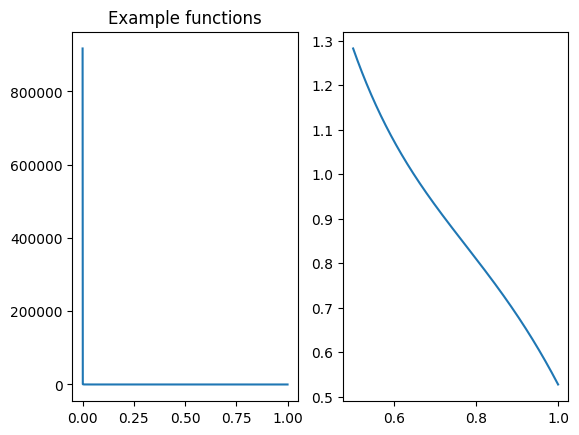

In [4]:
plt.figure("Example function")
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2)
xx2 = np.linspace((I.a+I.b)/2,I.b,1000)
plt.plot(xx2,ex_f(xx2))

Discretize and compress

In [5]:
k = 30
x_disc, w_disc, endpoints, intervals = adaptive_discretization(F, eps_disc, k, verbose=False)
U_disc, A, rank, u_list = compress_sequence_of_functions(F, x_disc, w_disc, eps_comp, k, intervals)

Visualise diagonal entry drop off

6


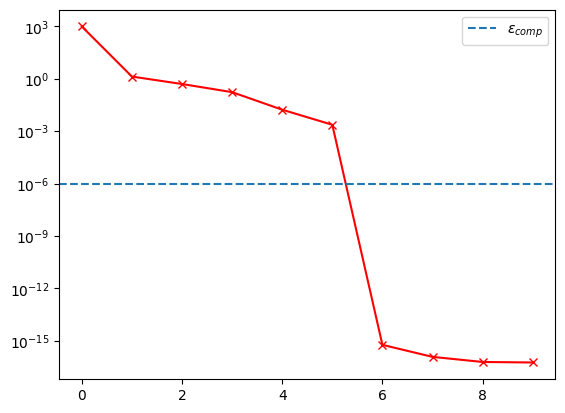

In [6]:
Q,R,perm = sp.linalg.qr(A, pivoting = True)
plt.semilogy(np.abs(np.diag(R)),"-xr");
plt.axhline(eps_comp,linestyle="--",label=r"$\varepsilon_{comp}$")
plt.legend()
print(rank)

Direction visualisation

(1e-06, 1.0)

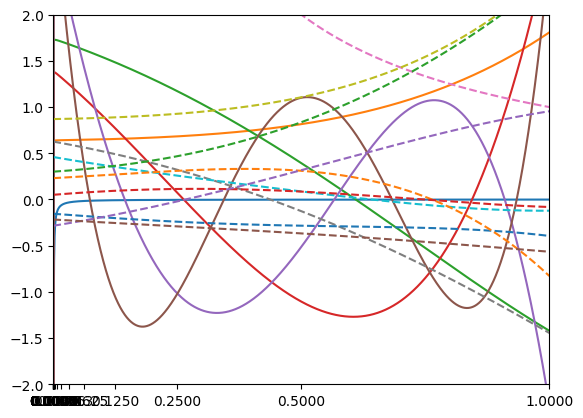

In [7]:
plt.figure();
plt.xticks(endpoints);
xx = np.linspace(I.a,I.b,2000)
for u in u_list:
    plt.plot(xx,u(xx));
for phi in F.functions:
    plt.plot(xx,phi(xx),"--");
plt.ylim(-2,2)
plt.xlim(I.a,I.b)

Chebyshev

In [8]:
x_cheb, w_cheb, idx_cheb = construct_Chevyshev_quadratures(x_disc,w_disc,U_disc)
print(F.target_integral(ex_f_expr), ex_f(x_disc)@w_disc, ex_f(x_cheb)@w_cheb)

12.0595227324296 12.059522732429564 12.059522732429645


Point comparison

Reduce number of points

In [9]:
# Implement damped gauss newton with Wolfe condition.
eps_quad = 0.3
r = U_disc.T@w_disc
x,w = point_reduction(x_cheb, w_cheb, r, u_list, eps_quad)
print("Quadrature length: ", len(x))

Quadrature length:  3


[0.034 0.169 0.381 0.619 0.831 0.966]
[0.    0.08  0.31  0.599 0.82  0.98 ]
[0.01  0.362 0.847]
Absolute integral error:  4.63362597358241e-6


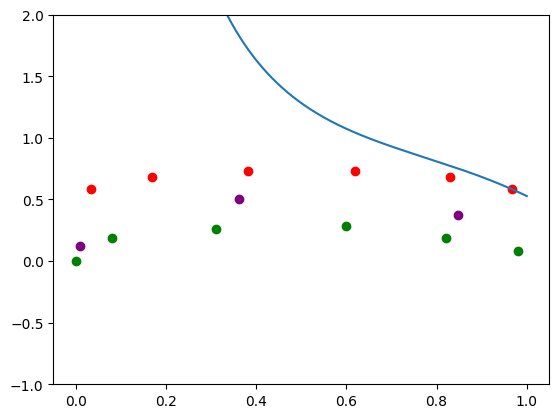

In [14]:
plt.figure()
plt.plot(xx, ex_f(xx))
plt.ylim(-1,2)
plt.scatter(x_cheb, w_cheb, c = 'green')
x_gl,w_gl = I.translate(np.polynomial.legendre.leggauss(rank))
plt.scatter(x_gl, w_gl, c = 'red')
plt.scatter(x, w, c = 'purple')
print(np.around(x_gl,3))
print(np.around(sorted(x_cheb),3))
print(np.around(x,3))

print("Absolute integral error: ", abs(F.target_integral(ex_f_expr) - ex_f(x)@w))

In [11]:
du_list = [u.deriv() for u in u_list]
def jacobian(y):
        x,w = np.split(y,2)
        U = np.column_stack([u(x) for u in u_list])
        dU = np.column_stack([du(x) for du in du_list])
        J = np.hstack([dU.T*w, U.T])
        return J
    
def residual(y):
    x,w = np.split(y,2)
    U = np.column_stack([u(x) for u in u_list])
    return U.T@w - r

y0 = np.concatenate([np.linspace(I.a,I.b,3), np.ones(3)])
y = dampened_gauss_newton(residual, jacobian, y0, step_size = 0.2, maxiter=int(1e5), tol = 1e-8)
x,w = np.split(y,2)
print(x)
print(w)
print(np.linalg.norm(residual(y)))

[0.01006079 0.3618472  0.8465837 ]
[0.12046973 0.5070944  0.37243487]
5.065323835852579e-09
